In [54]:
import torch as torch
from torch import nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib as matplotlib

In [55]:
matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=False)

In [56]:
if torch.cuda.is_available():
    cuda_id = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(cuda_id)
    device = "cuda:0"
else:
    device = "cpu"

NVIDIA GeForce RTX 3090


In [57]:
# torch.manual_seed(42)

## Creating Discriminator and Generator model classes

In [58]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        return self.network(img)

In [59]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, input):
        return torch.reshape(input, self.shape)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(64, 1024),
            # why NCHW :(
            Reshape((-1, 64, 4, 4)),
            nn.ConvTranspose2d(64, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 256, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 3, 5, 1, 2, bias=False),
            nn.Tanh(),
        )

    def forward(self, img):
        return self.network(img)

In [60]:
# return a vector of n samples from N(0,1) distribution
get_normal = lambda n: torch.normal(torch.zeros(n), 1).to(device)
normal_vector = get_normal(64)

In [61]:
generator = Generator().to(device)
forwarded_random_image = generator.forward(normal_vector)
forwarded_random_image.shape

torch.Size([1, 3, 32, 32])

In [62]:
def scale_and_display(image):
    plt.imshow((image.squeeze().permute(1, 2, 0).squeeze().detach().numpy() + 1) / 2)

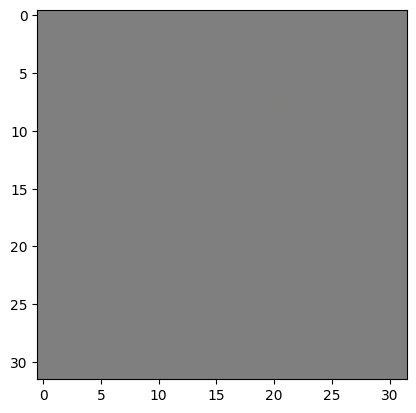

In [63]:
scale_and_display(torch.clone(forwarded_random_image).cpu())

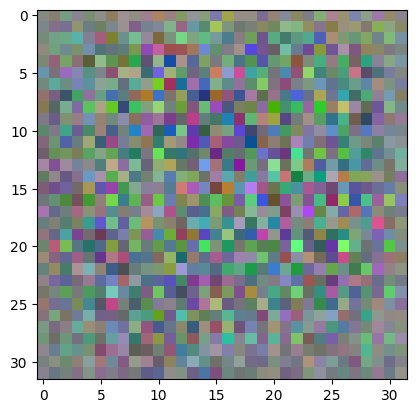

In [64]:
img = forwarded_random_image.cpu().permute(0, 2, 3, 1).squeeze().detach().numpy()
maximum = img.max()
minimum = img.min()
scaled_image = (img - minimum) / (maximum - minimum)
plt.imshow(scaled_image)

In [65]:
# Let's ensure that the Discriminator doesn't throw any obvious errors
discriminator = Discriminator().to(device)
discriminator.forward(forwarded_random_image)

tensor([[0.5855]], device='cuda:0', grad_fn=<SigmoidBackward0>)

## Loading the data

In [66]:
def lambda_scaling(tensor):
    return tensor * 2 - 1

In [67]:
data_dir = dset.ImageFolder(
    root=".",
    transform=transforms.Compose(
        [
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor(),
            transforms.Lambda(lambda_scaling),
        ]
    ),
)

In [68]:
data = torch.stack([element[0] for element in data_dir]).to(device)
data.shape

torch.Size([975, 3, 32, 32])

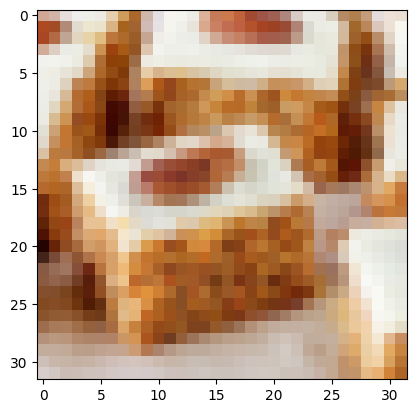

In [69]:
scale_and_display(torch.clone(data[2]).cpu())

In [70]:
data[0].shape

torch.Size([3, 32, 32])

## Example of training a non-standard model in a loop

In [71]:
class NonstandardModel(nn.Module):
    def __init__(self):
        super(NonstandardModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(10, 128),
            nn.Dropout(0.25),
            nn.ReLU(True),
            nn.Linear(128, 128),
            nn.Dropout(0.25),
            nn.ReLU(True),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        return self.network(img)

In [72]:
my_model = NonstandardModel().to(device)
for i, param in enumerate(my_model.parameters()):
    if not i in {0, 3}:  # 0 and 3 correspond to the first 2 fully connected layers
        param.requires_grad = False

In [73]:
# copy model parameters to compare them at the end
reference_list = []
for p in my_model.parameters():
    reference_list.append(torch.clone(p))

In [74]:
batch = torch.stack([get_normal(10) for _ in range(10)])
optimizer = torch.optim.SGD(
    my_model.parameters(), lr=0.001, momentum=0.9, nesterov=True
)
for epoch in range(1000):
    y_pred = my_model(batch)
    loss = -torch.log(42 - 42 * y_pred.mean())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(loss)

tensor(-3.0242, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-3.0608, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-3.0849, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-3.1261, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-3.1494, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-3.1540, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-3.1854, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-3.2067, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-3.2019, device='cuda:0', grad_fn=<NegBackward0>)
tensor(-3.2488, device='cuda:0', grad_fn=<NegBackward0>)


In [75]:
result_list = []
for p in my_model.parameters():
    result_list.append(p)

for ref, res in zip(reference_list, result_list):
    print((ref - res).sum())

tensor(-0.5724, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(-0.0212, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


## The basic idea of discriminator training

In [76]:
BATCH_SIZE = 16

In [87]:
real_batch = data[:BATCH_SIZE]
real_labels = torch.zeros(BATCH_SIZE)

generated_batch = generator.forward(
    torch.stack([get_normal(64) for _ in range(BATCH_SIZE)])
)
generated_labels = torch.ones(BATCH_SIZE)

batch = torch.concat([real_batch, generated_batch])
labels = torch.concat([real_labels, generated_labels])
labels += torch.rand(2 * BATCH_SIZE) * 0.1 - 0.05
labels = labels.clip(min=0, max=1).to(device)
labels = labels.reshape((-1, 1))

In [88]:
discriminator_opt = torch.optim.Adam(discriminator.parameters(), lr=0.00001)
loss_function = nn.BCELoss()

In [89]:
for epoch in range(1):  # Placeholder loop to copypaste later
    y_pred = discriminator(batch)
    loss = loss_function(y_pred, labels)

    discriminator_opt.zero_grad()
    loss.backward()
    discriminator_opt.step()

loss

tensor(0.7694, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

## The basic idea of discriminator training

In [90]:
batch = torch.stack([get_normal(64) for _ in range(BATCH_SIZE)])
labels = torch.ones(BATCH_SIZE) + torch.rand(BATCH_SIZE) * 0.1 - 0.05
labels = labels.clip(max=1).reshape((-1, 1)).to(device)

generator_opt = torch.optim.Adam(generator.parameters(), lr=0.00001)

In [91]:
for epoch in range(1):
    images = generator(batch)
    y_pred = discriminator(images)
    loss = loss_function(y_pred, labels)
    generator_opt.zero_grad()
    loss.backward()
    generator_opt.step()

loss

tensor(0.6436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)